### Structural error
+ this is the code to reproduce Figs. 6(a), 7 and 8.

In [1]:
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import numpy as np
import seaborn
import xarray
import functools
import copy
import pickle

from jax_cfd_test import my_equations
from jax_cfd_test import my_funcutils
from jax_cfd_test import my_forcing

from flax import linen as nn
from jax import random, numpy as jnp
from jax import grad

import optax

import time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
def sealed_convection_diffusion_true(measure_point_coordinate, center, stage):
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.001
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*10+41

    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force(grid,center_x=center_x, center_y=center_y)), outer_steps*inner_steps))
   

    last_step, _ = rollout_fn(G,time)
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    
    return data_fin, data_array_at_last_step
    
def sealed_convection_diffusion_nn(param, measure_point_coordinate, center, stage, model):
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.001
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*10+41

    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.reciprocal_force_with_nn(grid,center_x=center_x, center_y=center_y,params=param,model =model)), outer_steps*inner_steps))

    last_step, _ = rollout_fn(G,time)
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    
    return data_fin, data_array_at_last_step

In [4]:
from flax.traverse_util import flatten_dict, unflatten_dict

def reconstruct_array_to_dict(params_grad_array, grads):
    """
    reconstruct the raveled array into a dict

    inputs:
    - params_grad_array: raveled array
    - grads: initial dict for shape

    outputs:
    - reconstructed_grads: reconstructed dict
    """
    params_grad_flat = flatten_dict(grads)
    shapes = {k: v.shape for k, v in params_grad_flat.items()}

    index = 0
    reconstructed_params_grad_flat = {}
    for k, shape in shapes.items():
        size = size = int(np.prod(shape))  
        reconstructed_params_grad_flat[k] = jnp.reshape(params_grad_array[index:index+size], shape)
        index += size

    reconstructed_grads = unflatten_dict(reconstructed_params_grad_flat)

    return reconstructed_grads

def reconstruct_dict_to_array(grads):
    """
    ravel the dict into array

    input:
    - grads: dict of network parameters

    output:
    - params_grad_array: array
    """
    params_grad_flat = flatten_dict(grads)
    
    flat_arrays = [jnp.ravel(v) for v in params_grad_flat.values()]
    
    params_grad_array = jnp.concatenate(flat_arrays)
    
    return params_grad_array
    
def kl_divergence(mu1, sigma1, mu2, sigma2):
    sigma2_inv = jnp.linalg.inv(sigma2)
    
    term1 = jnp.trace(sigma2_inv @ sigma1)
    term2 = (mu2 - mu1).T @ sigma2_inv @ (mu2 - mu1)
    
    _, logdet_sigma1 = jnp.linalg.slogdet(sigma1)
    _, logdet_sigma2 = jnp.linalg.slogdet(sigma2)
    term3 = logdet_sigma2 - logdet_sigma1
    
    kl_div = 0.5 * (term1 + term2 - len(mu1) + term3)
    
    return kl_div

from jax import checkpoint

def predict_y_f(d_start, center, stage, model, ensemble_member_i):
    ensemble_member_i_dict = reconstruct_array_to_dict(ensemble_member_i,params)
    y_f, _ = sealed_convection_diffusion_nn(ensemble_member_i_dict, d_start, center, stage, model)
    return y_f

vmap_predict_y_f = jax.vmap(predict_y_f, in_axes=(None, None, None, None, 0))

def generate_sample(key, mean, std_dev):
    return mean + std_dev * jax.random.normal(key, shape=mean.shape)
     
def EKI_process_fixCenter(d_start, center, observation_local, ensemble_member, stage, model, noise_level_eki=1e-5, inflation_factor=1.0, step_size=0.5):
    
    ensemble_size_local = ensemble_member.shape[0]
    
    y_fs = vmap_predict_y_f(d_start, center, stage, model, ensemble_member)

    y_fs = y_fs.reshape((ensemble_size_local, 1))
    
    y_f_mean = jnp.mean(y_fs)
    
    P_yy = jnp.einsum('ij,ij->j', y_fs - y_f_mean, y_fs - y_f_mean) / (ensemble_size_local - 1)


    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    P_xy = jnp.einsum('ij,ik->jk', x_f_deviation, y_f_deviation) / (ensemble_size_local - 1)

    K = P_xy * 1.0/P_yy
    x_a = x_f_theta + step_size*jnp.matmul(K, (observation_local - y_fs).T).T
    
    x_a_mean = jnp.mean(x_a, axis=0)
    x_a = x_a_mean + inflation_factor * (x_a - x_a_mean)
    
    return x_a


def loss_function5(d_start, center, estimated_center, noise_level_eki):
    '''
    loss function for AD-EKI
    '''
    us = ensemble_members_array
    
    observation_local, _ = sealed_convection_diffusion_true(d_start, center, stage)
    
    def body(i, us):
        return checkpoint(EKI_process_fixCenter, static_argnums=(1, 2, 4, 5, 6, 7, 8))(d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size)
    
    us = jax.lax.fori_loop(0, 3, body, us)

    updated_mu = jnp.mean(us,axis=0)
    updated_sigma = jnp.cov(us, rowvar=False)
    
    #return jnp.trace(updated_sigma)
    return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)#, (updated_mu,updated_sigma)

Network Settings: 

learning_rate1 =  0.003
learning_rate2 =  [0.012 0.012 0.012 0.012 0.012 0.012]
learning_rate3 =  [0.002  0.0025 0.002  0.0018 0.0015 0.0009]
iteration_step_number1 =  (50, 45, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 30, 20)
iteration_step_number2 =  (10, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 100)
MAP range =  (5, 5, 5, 5, 5, 5, 5, 5, 5, 5)


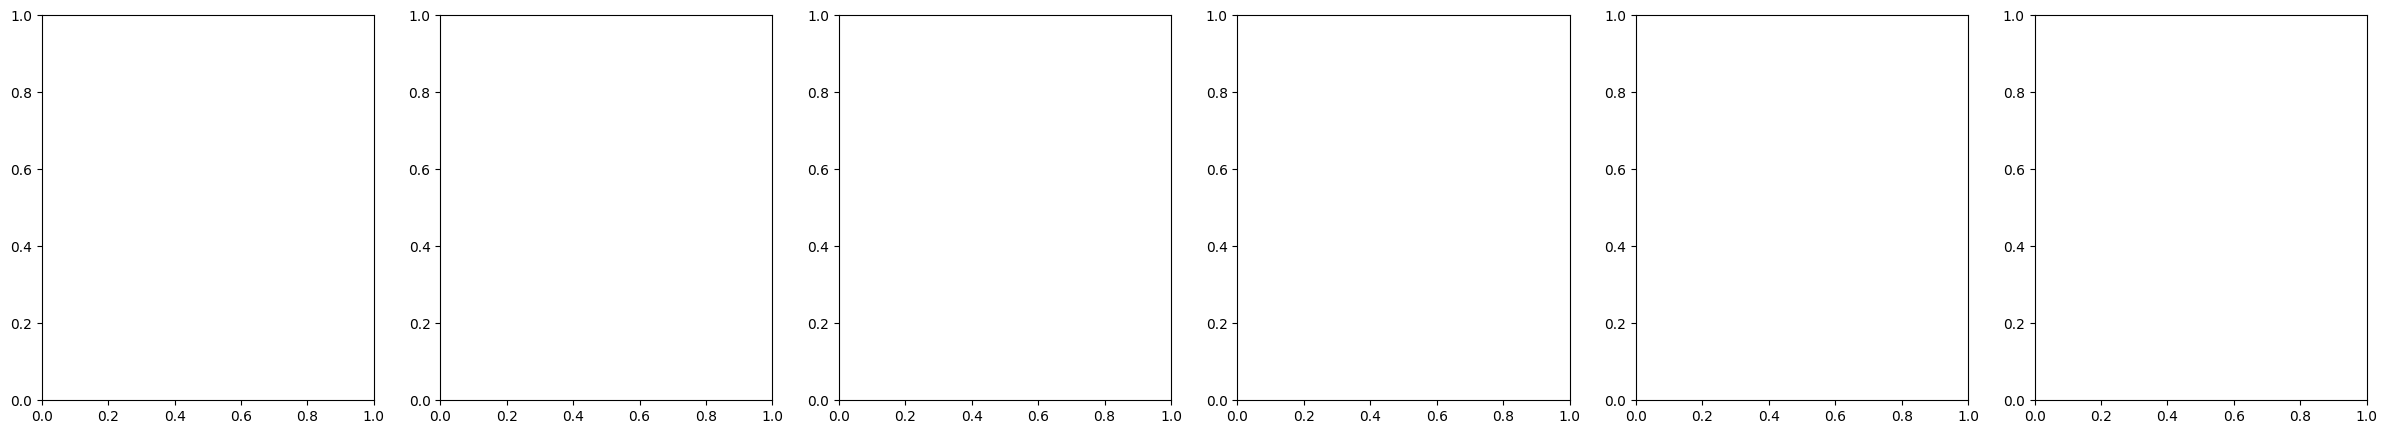

In [5]:
def log_normalize_pdf(log_probs):
    max_log_prob = jnp.max(log_probs)
    
    probs = jnp.exp(log_probs - max_log_prob)
    
    normalized_probs = probs / jnp.sum(probs)
    
    normalized_log_probs = jnp.log(normalized_probs+1e-32)
    
    return normalized_log_probs

def normalize_pdf(probs):
    return probs/jnp.sum(probs)

def calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model):
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    if num_d == 1.0:
        output_point, _ = sealed_convection_diffusion_true(d_start, center, stage)
        observation = output_point + jnp.array([0.0])

        false_center = jnp.array([1.0,1.0]) - d_start
        false_start = jnp.array([0.5, 0.5])
        _, output_all = sealed_convection_diffusion_nn(current_params, false_start, false_center, stage, model)
        output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
        xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
        xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
        output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
        loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=output_for_xb, scale=noise_base_scale+noise_ratio_scale*jnp.abs(output_for_xb))
    return loglikelihood

def calculate_info_gain(prior, posterior):
    '''
    KLD
    '''
    return jnp.sum(posterior*(jnp.log(posterior+1e-32) - jnp.log(prior+1e-32)))

def forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model):
    loglikelihood = calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    evidence_list = jnp.exp(log_evidence_list)
    posterior = evidence_list/jnp.sum(evidence_list)
    KLD = calculate_info_gain(prior, posterior)
    return KLD, posterior

def compute_gradient_norm(grad_params):
    squared_norms = jax.tree_util.tree_map(lambda x: jnp.sum(x**2), grad_params)
    total_squared_norm = sum(jax.tree_util.tree_leaves(squared_norms))
    total_norm = jnp.sqrt(total_squared_norm)
    return total_norm

'''
main
'''


# PDE settings =================
size = 251  
local_size = int((size-1)/5+1)
density = 1.
viscosity = 1

lo_b = -2. 
up_b = 3.

max_velocity = 2.0
cfl_safety_factor = 0.5


key = random.PRNGKey(2019)  
x_for_shape = random.normal(key, (1, 2))  

class localFullyConnectedNN2(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=4)(x)  
        x = nn.tanh(x)  # 激活函数
        x = nn.Dense(features=4)(x) 
        x = nn.tanh(x)  # 激活函数
        x = nn.Dense(features=1)(x) 
        return x
        
model = localFullyConnectedNN2() 


params = {'params': {'Dense_0': {'bias': jnp.array([-0.5034, -0.0280, -0.3198,  0.4847]),
           'kernel': jnp.array([[ 4.8153,  4.1794,  8.2351,  9.6484],
        [-2.8456,  5.2352, -8.0220, -9.1204]])},
          'Dense_1': {'bias': jnp.array([-0.4493,  1.2653,  1.2336,  0.4221]),
           'kernel': jnp.array([[-0.7218,  2.8800,  3.2308,  1.1351],
        [-5.0888,  4.8622,  4.7844,  5.0217],
        [-2.9412,  3.9048, -4.2149, -5.2085],
        [ 4.3755, -3.2684,  4.4775,  3.3922]])},
          'Dense_2': {'bias': jnp.array([-0.3442]),
           'kernel': jnp.array([[-10.5900],
        [ 10.0693],
        [-10.0099],
        [-10.6412]])}}
         }

params_shape = {'params': {'Dense_0': {'bias': jnp.array([0, 0, 0, 0]),
           'kernel': jnp.array([[0, 0, 0, 0],
        [0, 0, 0, 0]])},
          'Dense_1': {'bias': jnp.array([0, 0, 0, 0]),
           'kernel': jnp.array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])},
          'Dense_2': {'bias': jnp.array([0]),
           'kernel': jnp.array([[0],
        [0],
        [0],
        [0]])}}
         }


# OED settings =================
n_stage = 6
d_start = jnp.array([0.5,0.5])
center = jnp.array([0.25,0.25])

d_change_range = jnp.array([0.2,0.2])
d_change_range_MEC = jnp.array([0.35,0.35])

noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

num_d = 1.0
radio_d = 0.5

xb_size = int((size - 1)/5+1) 
prior_ori = jnp.ones((xb_size,xb_size))
prior = prior_ori/jnp.sum(prior_ori)

key = random.split(key,int(n_stage*2+1))

    
def loss_param_refine5(current_params, d_start, stage, estimated_center, model, observation):

    y_f, _ = sealed_convection_diffusion_nn(current_params, d_start, estimated_center, stage, model)
    loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=y_f, scale=noise_base_scale+noise_ratio_scale* jnp.abs(y_f))

    return -loglikelihood


def loss_param_refine6(current_params, design_MEC_array, stage_count_array, estimated_center, observation_MEC_array):
    def single_stage_loglikelihood(design_MEC, observation_MEC, stage_MEC):
        stage_MEC = int(stage_MEC)  
        y_f, _ = sealed_convection_diffusion_nn(current_params, design_MEC, estimated_center, stage_MEC, model)
        return jax.scipy.stats.norm.logpdf(
            observation_MEC, loc=y_f, scale=noise_base_scale + noise_ratio_scale * jnp.abs(y_f)
        )

    loglikelihoods = [
        single_stage_loglikelihood(design_MEC, observation_MEC, stage_MEC)
        for design_MEC, observation_MEC, stage_MEC in zip(design_MEC_array, observation_MEC_array, stage_count_array)
    ]

    return -jnp.sum(jnp.array(loglikelihoods))
    


def loss_design(d_start, current_params, stage, center, prior, noise_info, num_d, radio_d, key, model):
    KLD, _ = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model)
    return -KLD

def evaluate_nn_accuracy(params,model,center,local_size):
    grid = cfd.grids.Grid((local_size, local_size), domain=((0, 1), (0, 1)))
    offsets = ((0.5,0.5),(0.5,0.5))
    x = grid.mesh(offsets[1])[0]
    y = grid.mesh(offsets[0])[1]
    center_x = center[0]
    center_y = center[1]
    exponent_internal = ((x-center_x)**2.0+(y-center_y)**2.0)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 **2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 **2.0))
    array_reciprocal = factor*1.5 / (exponent_internal**2 / (2.0 * 0.05 **2.0)**2+ 1.0)
    x_reshaped = x.reshape(-1, 1) - center_x
    y_reshaped = y.reshape(-1, 1) - center_y
    xy_combined = jnp.concatenate((x_reshaped, y_reshaped), axis=1)
    array_nn = model.apply(params,xy_combined).reshape(grid.shape)
    return jnp.sum((array_exponent - array_reciprocal - array_nn)**2)


#iteration_step_number1 = tuple((50,40,30,20,20,20,20,20,20,20))
iteration_step_number1 = tuple((50,45,40,40,40,40,40,40,40,40,40,40,40,30,20))
#iteration_step_number2 = tuple((10,50,50,50,50,50,50,50,100,100))
iteration_step_number2 = tuple((10,80,80,80,80,80,80,80,80,80,80,80,80,80,100))
num_top_array = tuple((5,5,5,5,5,5,5,5,5,5))#((1,1,1,1,1,1,1,1,1,1))#

stage_to_skip = [0]

fig, axes = plt.subplots(1, n_stage, figsize=(5*n_stage, 5))
grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

learning_rate1 = 0.003
learning_rate2 = jnp.ones(n_stage)*0.012
learning_rate3 = jnp.array([0.002,0.0025,0.002,0.0018,0.0015,0.0009])

print('Network Settings: \n')
print(f'learning_rate1 = ', learning_rate1)
print(f'learning_rate2 = ', learning_rate2)
print(f'learning_rate3 = ', learning_rate3)
print(f'iteration_step_number1 = ', iteration_step_number1)
print(f'iteration_step_number2 = ', iteration_step_number2)
print(f'MAP range = ', num_top_array)

inflation_factor = 1.0
step_size = 0.5

KLD_list=[]
evidence_list=[]
NN_error_list=[]
gradient_norm_list=[]
params_list=[]
design_list = []
design_list.append(d_start)
posterior_list = []
posterior_oed_list = []
estimated_posterior_point = []
ensemble_mean_trajectory_list = []
ensemble_cov_trajectory_list = []
design_MEC_trajectory = []
KLD_MEC_list = []
actual_step = []
design_MEC_list = []
observation_MEC_list = []


In [6]:
for stage in range(n_stage):
        
    print('\n stage = ', stage, '\n')
    key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
    key_for_param = random.split(key[stage*2+1],(iteration_step_number2[stage]+1))

    
    clip_count = 0
    
    if stage!=0:
        try:
            del tx1
            del opt_state1
        except NameError:
            pass
    else:
        print(f'stage = 0, only run forward model and update posterior')
        
    tx1 = optax.chain(
    optax.adam(learning_rate1),
    optax.add_decayed_weights(1e-4) 
    )
    
    opt_state1 = tx1.init(d_start)
    
    d_limit_min = d_start - d_change_range
    d_limit_max = d_start + d_change_range
    
    start_time = time.time()
    d_start_backup = d_start

    print('start learning design')
    print(f'start design : ', d_start)
    for i in range(iteration_step_number1[stage]):
        negtive_KLD, grad_design = jax.value_and_grad(loss_design)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model)
        updates, opt_state1 = tx1.update(grad_design, opt_state1, params=d_start)

        
        # 解决nan的问题
        oed_nan_index = 0
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            oed_nan_index = oed_nan_index + 1
            print(f'NaN appears in learning. Perturb params and continue. Nan count: {oed_nan_index}')
            noise = 0.05*jax.random.normal(key_for_design[i], d_start.shape)
            d_start = d_start+ noise
        else:
            oed_nan_index = 0
            d_start = optax.apply_updates(d_start, updates)
    
        d_start_before_clip = d_start
        d_start = jnp.clip(d_start, d_limit_min, d_limit_max)
        
        clip_count = 0
        if not jnp.all(d_start == d_start_before_clip):
            clip_count += 1
        else:
            clip_count = 0
            
        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            break
        
        if np.isnan(d_start).any() or np.isnan(negtive_KLD).any():
            print('some results are Nan')
            break
    
        KLD_list.append(-negtive_KLD)
        
        if oed_nan_index > 6:
            print('Nan keep appearing for 6 times, stop BED')
            break
            
            
    end_time = time.time()
    print(f"Execution learning design time: {end_time - start_time} seconds")
    print('Current design = ', d_start)

    #if stage!=0:
    _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
    del prior 
    prior = posterior 
    posterior_oed_list.append(posterior)

    net_accuracy = evaluate_nn_accuracy(params,model,center,local_size)
    NN_error_list.append(net_accuracy)
    design_list.append(d_start)
    

    

    num_top = num_top_array[stage]
    indices = jnp.argpartition(posterior.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior.shape)
    
    average_x = int(jnp.mean(multi_indices[0]))
    average_y = int(jnp.mean(multi_indices[1]))
    
    x_range = jnp.arange(max(0, average_x - 2), min(posterior.shape[0], average_x + 3))
    y_range = jnp.arange(max(0, average_y - 2), min(posterior.shape[1], average_y + 3))
    
    x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
    x_grid_flat = x_grid.ravel()
    y_grid_flat = y_grid.ravel()
    
    grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
    grid_values = posterior[x_grid_flat, y_grid_flat]
    
    fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
    fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
    fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
    fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)
    
    interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
    interpolated_values = interpolated_values.reshape(fine_x_grid.shape)
    
    max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
    max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]
    
    estimated_center = jnp.array([max_x, max_y]) / 50
    print(f'estimated_center is ', estimated_center)
    estimated_posterior_point.append(estimated_center)



    if stage in stage_to_skip:
        posterior_list.append(posterior)
        params_list.append(params)
        actual_step.append(0)
        continue


    

    start_time = time.time()
    print(f'design from OED is {d_start}')
    ensemble_size = 40

    std_dev = 0.3
    mean_array = reconstruct_dict_to_array(params)
    params_dimension = len(mean_array)



    observation, _ = sealed_convection_diffusion_true(d_start, center, stage)
    d_start_MEC = d_start 
    print(f'start design : ', d_start_MEC)
    print('observation of start design = ', observation)

    try:
        del tx2
        del opt_state2
    except NameError:
        pass
    
    tx2 = optax.chain(
        optax.adam(0.012),
    )
    
    opt_state2 = tx2.init(d_start_MEC)
    
    d_limit_min = d_start_MEC - d_change_range_MEC
    d_limit_max = d_start_MEC + d_change_range_MEC

    print('start learning design')

    clip_count = 0
    
    noise_level_eki = 5e-5
    key_ensemble_pass = key_for_param[-1]
    
    for i in range(70):
        
        key_ensemble_pass, key_ensemble_pass_sub = random.split(key_ensemble_pass)
        key_ensemble = random.split(key_ensemble_pass_sub,ensemble_size)
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_ensemble, mean_array, std_dev)
        
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    
        negtive_KLD, grad_design = jax.value_and_grad(loss_function5)(d_start_MEC, center, estimated_center, 0.0002)
        updates, opt_state2 = tx2.update(grad_design, opt_state2, params=d_start_MEC)
        
        d_start_MEC = optax.apply_updates(d_start_MEC, updates)
    

        d_start_before_clip = d_start_MEC
        d_start_MEC = jnp.clip(d_start_MEC, d_limit_min, d_limit_max)
        design_MEC_trajectory.append(d_start_MEC)
        
        if not jnp.all(d_start_MEC == d_start_before_clip):
            clip_count += 1
        
        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            actual_step.append(i+1)
            break
            
        if isinstance(negtive_KLD, (list, tuple)):
            KLD_MEC_list.append(-negtive_KLD[0])  
        else:
            KLD_MEC_list.append(-negtive_KLD)     

        if i == 69:
            actual_step.append(i+1)

        print('.',end='')

    print('\n')
    print('updated design : ', d_start_MEC)

    
    observation, _ = sealed_convection_diffusion_true(d_start_MEC, center, stage)
    print('observation of updated design = ', observation)
    design_MEC_list.append(d_start_MEC)
    observation_MEC_list.append(observation)
    
    try:
        del tx2
        del opt_state2
    except NameError:
        pass
    
    
    print(f'design for model correction is {d_start_MEC}')
    end_time = time.time()
    print(f"Execution finding design for model correction time: {end_time - start_time} seconds")



    start_time = time.time()
    try:
        del tx3
        del opt_state3
    except NameError:
        pass
        
    tx3 = optax.adam(learning_rate3[stage])
    
    opt_state3 = tx3.init(params)
    observation, _ = sealed_convection_diffusion_true(d_start_MEC, center, stage)
    print(f'measurement is: {observation}')
    design_MEC_array = jnp.array(design_MEC_list)
    observation_MEC_array = jnp.array(observation_MEC_list)
    stage_count_array = jnp.arange(1,stage+1)

    print('start learning params')
    for i in range(iteration_step_number2[stage]):
        if stage in stage_to_skip:
            print(f'stage {stage} dont learn error parameters')
            break
        
        estimated_center_perturbed = estimated_center + 0.05 * jax.random.normal(key_for_param[i], estimated_center.shape)*jnp.exp(-0.04*i)#* (80-i)/80
        max_evidence_items, grad_params = jax.value_and_grad(loss_param_refine6)(params, design_MEC_array, stage_count_array, estimated_center_perturbed, observation_MEC_array)
    
        clip_norm = 1e10
        clip_transform = optax.clip_by_global_norm(clip_norm)
        clipped_grads, _ = clip_transform.update(grad_params, state=None)
        
        updates, opt_state3 = tx3.update(clipped_grads, opt_state3, params=params)
        
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            print('NaN appears in learning. Perturb params and continue.')
            noise = jax.tree_util.tree_map(lambda p: 0.01 * jax.random.normal(key_for_param[i], p.shape), params)
            params = jax.tree_util.tree_map(lambda p, n: p + n, params, noise)
        else:
            params = optax.apply_updates(params, updates)
            
        net_accuracy = evaluate_nn_accuracy(params,model,center,local_size)
        
        if np.isnan((max_evidence_items, net_accuracy)).any():
            print('some results are Nan')
            break
            
        evidence_list.append(-max_evidence_items)
        NN_error_list.append(net_accuracy)
        print('.',end='')

        
    params_list.append(params)
    
    end_time = time.time()
    print(f"Execution learning param time: {end_time - start_time} seconds")

    if stage not in stage_to_skip:
        _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
        if stage!=0:
             del prior
        prior = posterior
        
    posterior_list.append(posterior)
        


 stage =  0 

stage = 0, only run forward model and update posterior
start learning design
start design :  [0.5 0.5]
Execution learning design time: 85.67257475852966 seconds
Current design =  [0.32696426 0.32690698]
estimated_center is  [0.24 0.22]

 stage =  1 

start learning design
start design :  [0.32696426 0.32690698]
Execution learning design time: 75.26512050628662 seconds
Current design =  [0.22245525 0.22217366]
estimated_center is  [0.16 0.28]
design from OED is [0.22245525 0.22217366]
start design :  [0.22245525 0.22217366]
observation of start design =  0.5645024
start learning design
......................................................................

updated design :  [0.1408993  0.29823673]
observation of updated design =  0.35936654
design for model correction is [0.1408993  0.29823673]
Execution finding design for model correction time: 275.67734575271606 seconds
measurement is: 0.3593665361404419
start learning params
............................................

In [8]:
# save data
import pickle

numpy_list = [np.array(arr) for arr in posterior_list]
data_to_save = {
    "posterior_list": numpy_list,
    "posterior_oed_list": posterior_oed_list,
    "design_list": design_list,
    "params_list": params_list,
    "estimated_posterior_point": estimated_posterior_point,
    "design_MEC_trajectory": design_MEC_trajectory,
    
    "actual_step": actual_step,
    "design_MEC_list": design_MEC_list,
    "observation_MEC_list": observation_MEC_list
}

with open('all_data_nn_case_seed_2019.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


In [16]:
import pickle

# 
with open('all_data_nn_case_seed_2019.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 
posterior_list = loaded_data["posterior_list"]
posterior_oed_list = loaded_data["posterior_oed_list"]
design_list = loaded_data["design_list"]
params_list = loaded_data["params_list"]
estimated_posterior_point = loaded_data["estimated_posterior_point"]
design_MEC_trajectory = loaded_data["design_MEC_trajectory"]
actual_step = loaded_data["actual_step"]
design_MEC_list = loaded_data["design_MEC_list"]
observation_MEC_list = loaded_data["observation_MEC_list"] 

In [9]:
import jax.numpy as jnp
from scipy.interpolate import griddata

num_top = 1
for i in range(n_stage):
    indices = jnp.argpartition(posterior_list[i].ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior_list[i].shape)
    
    average_x = int(jnp.mean(multi_indices[0]))
    average_y = int(jnp.mean(multi_indices[1]))
    
    x_range = jnp.arange(max(0, average_x - 2), min(posterior_list[i].shape[0], average_x + 3))
    y_range = jnp.arange(max(0, average_y - 2), min(posterior_list[i].shape[1], average_y + 3))
    
    x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
    x_grid_flat = x_grid.ravel()
    y_grid_flat = y_grid.ravel()
    
    grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
    grid_values = posterior_list[i][x_grid_flat, y_grid_flat]
    
    fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
    fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
    fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
    fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)
    
    interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
    interpolated_values = interpolated_values.reshape(fine_x_grid.shape)
    
    max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
    max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]
    
    estimated_center_post = jnp.array([max_x, max_y]) / 50
    
    distance = jnp.sqrt(jnp.sum((center - estimated_center_post)**2))
    print(f'stage {i}, estimated_center is {estimated_center_post}, distance is {distance}')


stage 0, estimated_center is [0.18285714 0.4212245 ], distance is 0.18391844630241394
stage 1, estimated_center is [0.16081633 0.22734693], distance is 0.09201569855213165
stage 2, estimated_center is [0.25428572 0.237551  ], distance is 0.013166052289307117
stage 3, estimated_center is [0.257551  0.2342857], distance is 0.017434366047382355
stage 4, estimated_center is [0.2408163  0.25265306], distance is 0.00955924578011036
stage 5, estimated_center is [0.2408163 0.2510204], distance is 0.009240219369530678


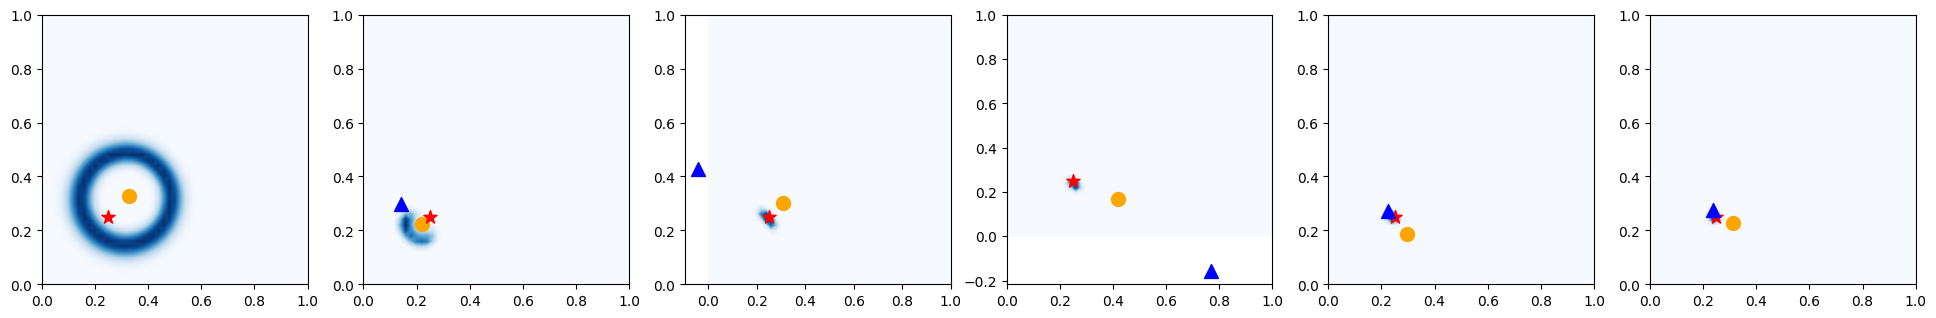

In [7]:
fig, axes = plt.subplots(1, n_stage, figsize=(4.03*n_stage, 3.5))
fig.subplots_adjust(wspace=0.21)

# fig.subplots_adjust(left = 0.05, right = 0.9, wspace=0.3)

grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

        
fontsize = 23
pic_num=0

# 内置颜色图
cmap = 'Blues'#'PuBu'#'pink'#'GnBu'#'Greens'#
star_color = 'r'#'magenta'#'y'#'#F89054'#


for stage in range(n_stage):
    d_start = design_list[stage+1]
    d_start_backup = design_list[stage]
    contour=axes[stage ].contourf(grid_x_plot0, grid_y_plot0, posterior_list[stage].T, levels=100,cmap=cmap)#plasma' )
    axes[stage ].scatter(d_start[0], d_start[1], marker='o', s=100, c='orange')
    axes[stage].scatter(center[0], center[1], marker='*', s=100, c=star_color)
    if stage not in stage_to_skip:
        try:
            axes[stage].scatter(design_MEC_list[stage-1][0], design_MEC_list[stage-1][1], marker='^', s=100, c='blue')
        except NameError:
            axes[stage].scatter(design_MEC_trajectory[np.sum(actual_step[:stage+1])-1][0], design_MEC_trajectory[np.sum(actual_step[:stage+1])-1][1], marker='^', s=100, c='blue')

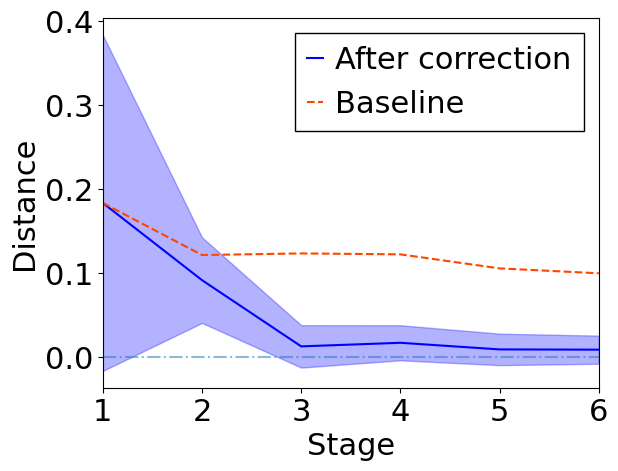

In [15]:
import jax.numpy as jnp
from scipy.interpolate import griddata

dis1_list = []
dis2_list = []

num_top = 1
for i in range(n_stage):
    indices = jnp.argpartition(posterior_list[i].ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior_list[i].shape)
    
    average_x = int(jnp.mean(multi_indices[0]))
    average_y = int(jnp.mean(multi_indices[1]))
    
    x_range = jnp.arange(max(0, average_x - 2), min(posterior_list[i].shape[0], average_x + 3))
    y_range = jnp.arange(max(0, average_y - 2), min(posterior_list[i].shape[1], average_y + 3))
    
    x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
    x_grid_flat = x_grid.ravel()
    y_grid_flat = y_grid.ravel()
    
    grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
    grid_values = posterior_list[i][x_grid_flat, y_grid_flat]
    
    fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
    fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
    fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
    fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)
    
    interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
    interpolated_values = interpolated_values.reshape(fine_x_grid.shape)
    
    max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
    max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]
    
    estimated_center_post1 = jnp.array([max_x, max_y]) / 50
    
    distance1 = jnp.sqrt(jnp.sum((center - estimated_center_post1)**2))
    dis1_list.append(distance1)


from scipy.stats import chi2

std_unc1 = np.zeros(n_stage)
std_unc2 = np.zeros(n_stage)
std_unc3 = np.zeros(n_stage)

for i in range(n_stage):
    posterior = posterior_list[i]
    
    n_points = posterior.shape[0]  
    x = np.linspace(0, 1, n_points)
    y = np.linspace(0, 1, n_points)
    x_grid, y_grid = np.meshgrid(x, y)
    
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()
    posterior_flat = posterior.flatten()
    
    mean_x = np.sum(x_flat * posterior_flat)
    mean_y = np.sum(y_flat * posterior_flat)
    
    cov_xx = np.sum((x_flat - mean_x) ** 2 * posterior_flat)
    cov_yy = np.sum((y_flat - mean_y) ** 2 * posterior_flat)
    cov_xy = np.sum((x_flat - mean_x) * (y_flat - mean_y) * posterior_flat)
    
    cov_matrix = np.array([
        [cov_xx, cov_xy],
        [cov_xy, cov_yy]
    ])
    
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    std_unc1[i]=(eigenvalues[0]*eigenvalues[1])**(1/4)
    std_unc2[i]=(eigenvalues[0]+eigenvalues[1])/2
    
    #print((eigenvalues[0]*eigenvalues[1])**(1/4),(eigenvalues[0]+eigenvalues[1])/2)
    
    confidence_level = 0.95
    chi2_value = chi2.ppf(confidence_level, df=2)  
    scaling_factor = np.sqrt(chi2_value)
    
    confidence_metric = np.pi * np.sqrt(eigenvalues[0] * eigenvalues[1]) * scaling_factor
    #print(f"Confidence Metric (area): {np.sqrt(confidence_metric/np.pi)}")

    std_unc3[i]=np.sqrt(confidence_metric/np.pi)

plt.rc('font', size=22)

plt.plot(dis1_list,color='b',label='After correction')

distance_base = [0.1839,0.1219,0.1238,0.1227,0.1060,0.10015]
stages = [0, 1, 2, 3, 4, 5]

plt.plot(stages, distance_base, label="Baseline", linestyle='--',color='orangered')

plt.xlim([0,5])
plt.xticks(ticks=[0,1,2,3,4,5],labels=[1,2,3,4,5,6])
plt.xlabel('Stage')
plt.ylabel('Distance')
plt.legend(
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=0.5,
    fancybox=False,  
    handletextpad=0.4 
)

plt.fill_between(range(n_stage),dis1_list+1*std_unc3, dis1_list-1*std_unc3, color='b',alpha=0.3)

plt.axhline(0.0,linestyle='-.',alpha=0.5)
#plt.savefig('nn case distance.png',dpi=300,bbox_inches='tight')

Text(0, 0.5, '$z_y$')

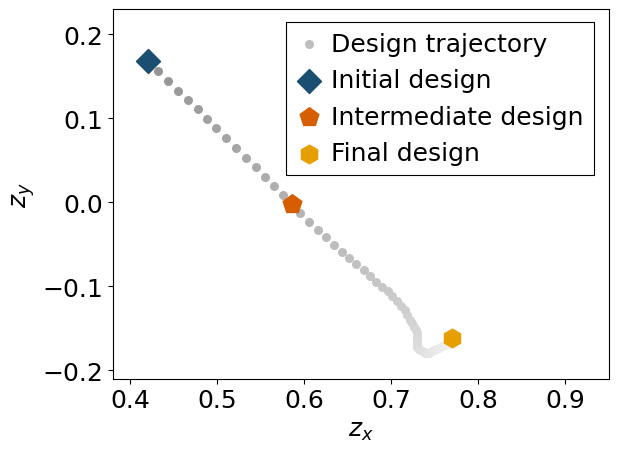

In [13]:
stage = 3
start_index = int(np.sum(actual_step[:stage]))
end_index = int(np.sum(actual_step[:stage+1]))-2

d1 = design_list[stage+1]
d2 = design_MEC_trajectory[int(start_index+(end_index-start_index)/4)-1]
d3 = design_MEC_trajectory[end_index]

plt.rc('font', size=18)
plt.figure(figsize=(6.4, 4.8))


colors = plt.cm.Greys(np.linspace(0.5, 0.05, 70))
for stage in [3]:
    for i in range(int(np.sum(actual_step[:stage])),int(np.sum(actual_step[:stage+1]))):
        if i == int(np.sum(actual_step[:stage]))+20:
            plt.scatter(design_MEC_trajectory[i][0], 
               design_MEC_trajectory[i][1], 
               color=colors[i-int(np.sum(actual_step[:stage]))],
                   s=30,
                       label='Design trajectory')
        else:
            plt.scatter(design_MEC_trajectory[i][0], 
               design_MEC_trajectory[i][1], 
               color=colors[i-int(np.sum(actual_step[:stage]))],
                   s=30)

plt.scatter(d1[0],d1[1],marker='D',s=150,color='#1B4F72',label='Initial design')
plt.scatter(d2[0],d2[1],marker='p',s=200,color='#D55E00',label='Intermediate design')
plt.scatter(d3[0],d3[1],marker='h',s=180,color='#E69F00',label='Final design')
plt.xlim([0.38,0.95])
plt.ylim([-0.21,0.23])

legend = plt.legend(
    loc=(0.35, 0.55),
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=1,
    fancybox=False,
    handletextpad=0.4
)
legend.get_frame().set_linewidth(0.8)

plt.xlabel('$z_x$')
plt.ylabel('$z_y$')
#plt.savefig('nn case design trajectory.png',dpi=300,bbox_inches='tight')

In [27]:
def loss_function_hist(d_start, center, estimated_center, noise_level_eki):
    us = ensemble_members_array
    us_history = []
    
    observation_local, _ = sealed_convection_diffusion_true(d_start, center, stage)
    
    for _ in range(3):
        us = EKI_process_fixCenter(
            d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size
        )
        us_history.append(us)

    return us_history

stage = 3
start_index = int(np.sum(actual_step[:stage]))
end_index = int(np.sum(actual_step[:stage+1]))-2
print(start_index, end_index)
params = params_list[stage-1]

d1 = design_list[stage+1]#design_MEC_trajectory[start_index]
d2 = design_MEC_trajectory[int(start_index+(end_index-start_index)/4)-1]
d3 = design_MEC_trajectory[end_index]

estimated_center = estimated_posterior_point[stage]
mean_array = reconstruct_dict_to_array(params)
key_ensemble_pass, key_ensemble_pass_sub = random.split(key[-1])
kld_array = np.zeros((9,50))

for j in range(50):
    print('-', end='')

print('|')

for j in range(50):
    key_ensemble_pass, key_ensemble_pass_sub = random.split(key_ensemble_pass)
    key_ensemble = random.split(key_ensemble_pass_sub, 40)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_ensemble, mean_array, 0.3)
    
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    
    
    u_his = loss_function_hist(d1, center, estimated_center, 0.0002)
    
    for i in range(3):
        updated_mu = jnp.mean(u_his[i], axis=0) 
        updated_sigma = jnp.cov(u_his[i], rowvar=False)
    
        kld_array[i,j] = -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)
    
    u_his = loss_function_hist(d2, center, estimated_center, 0.0002)
    
    for i in range(3):
        updated_mu = jnp.mean(u_his[i], axis=0) 
        updated_sigma = jnp.cov(u_his[i], rowvar=False)
    
        kld_array[i+3,j] = -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)
    
    u_his = loss_function_hist(d3, center, estimated_center, 0.0002)
    
    for i in range(3):
        updated_mu = jnp.mean(u_his[i], axis=0) 
        updated_sigma = jnp.cov(u_his[i], rowvar=False)
    
        kld_array[i+6,j] = -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)

    print('.', end='')

119 181
--------------------------------------------------|
..................................................

In [28]:
kld_mean = -np.mean(kld_array, axis=1) 
kld_reshaped = kld_mean.reshape(3, 3)

kld_with_zeros = np.hstack([np.zeros((3, 1)), kld_reshaped])

result = kld_with_zeros.flatten()

print(result)

[0.         0.32896397 0.92985229 1.57276443 0.         0.44390774
 1.18242504 1.90999565 0.         0.48070415 1.25429558 1.99624302]


Text(0, 0.5, 'KL divergence')

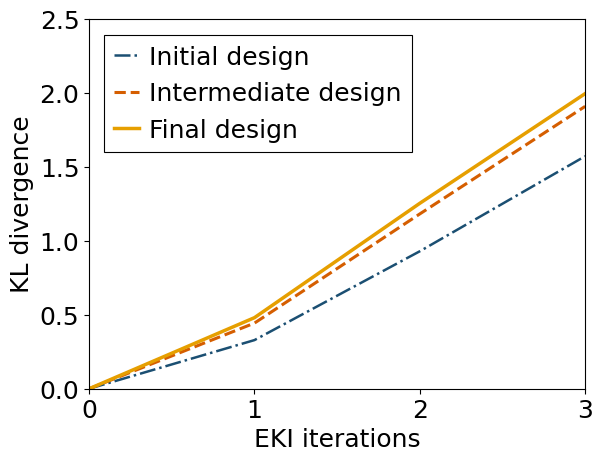

In [29]:
plt.rc('font', size=18)#22)
plt.plot(result[0:4],color='#1B4F72',linestyle='-.',linewidth=1.8,label='Initial design')
plt.plot(result[4:8],color='#D55E00',linestyle='--',linewidth=2.2,label='Intermediate design')
plt.plot(result[8:12],color='#E69F00',linestyle='-',linewidth=2.5,label='Final design')
legend = plt.legend(
    loc=(0.03, 0.64),
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=1,
    fancybox=False,
    handletextpad=0.4
)
legend.get_frame().set_linewidth(0.8)
plt.xlim([0,3])
plt.xticks([0,1,2,3])
plt.ylim([0,2.5])
plt.xlabel('EKI iterations')
plt.ylabel('KL divergence')
#plt.savefig('nn case eki.png',dpi=300,bbox_inches='tight')